In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

# Configure matplotlib to show plots inline
%matplotlib inline

In [3]:
print("Loading MNIST dataset...")
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Loading MNIST dataset...
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Loading MNIST dataset...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training model... (This may take a minute)
Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.8231 - loss: 0.5525 - val_accuracy: 0.9792 - val_loss: 0.0638
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9602 - loss: 0.1337 - val_accuracy: 0.9861 - val_loss: 0.0449
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9737 - loss: 0.0926 - val_accuracy: 0.9864 - val_loss: 0.0391
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9777 - loss: 0.0756 - val_accuracy: 0.9894 - val_loss: 0.0344
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9796 - loss: 0.0676 - val_accuracy: 0.9897 - val_loss: 0.0306
Model saved to Google Drive.


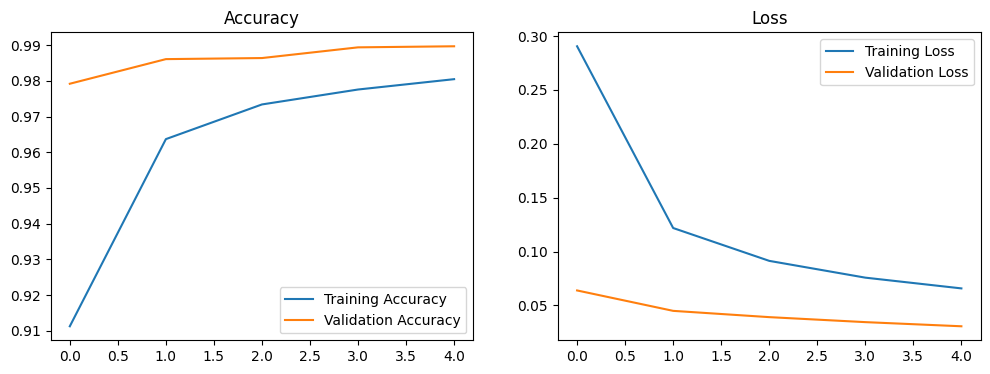

In [ ]:
print("Loading MNIST dataset...")
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize
x_train, x_test = x_train / 255.0, x_test / 255.0

# Reshape
x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1))

# CNN Model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train
print("Training model... (This may take a minute)")
history = model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test), verbose=1)


model.save('/content/drive/MyDrive/mnist_digit_classifier.keras')
print("Model saved to Google Drive.")


# Plot Results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
def preprocess_frame(roi):
    """
    Takes a region of interest (ROI) image, converts to grayscale,
    applies thresholding, and resizes to 28x28 for the model.
    """
    # Convert to grayscale
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

    # Gaussian blur to remove noise
    gray = cv2.GaussianBlur(gray, (7, 7), 0)

    # Thresholding
    _, thresh = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Resize
    resized = cv2.resize(thresh, (28, 28), interpolation=cv2.INTER_AREA)

    # Normalize and reshape
    normalized = resized / 255.0
    reshaped = normalized.reshape(1, 28, 28, 1)

    return reshaped, thresh

In [7]:
# Initialize Webcam
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: Could not access the webcam.")
else:
    print("Starting webcam... Press 'q' in the popup window to stop.")

    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            # bounding box
            x, y, w, h = 180, 100, 300, 300

            # Draw box
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)

            # Extract ROI
            roi = frame[y:y+h, x:x+w]

            # Process ROI
            input_data, processed_roi = preprocess_frame(roi)

            # Predict
            prediction = model.predict(input_data, verbose=0)
            digit = np.argmax(prediction)
            confidence = np.max(prediction)

            # Display result on screen
            label = f"Digit: {digit} ({confidence*100:.1f}%)"
            cv2.putText(frame, label, (x, y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

            cv2.imshow('Digit Recognizer', frame)
            cv2.imshow('AI Input', processed_roi)

            # Exit
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

    finally:
        cap.release()
        cv2.destroyAllWindows()
        print("Webcam released.")

Error: Could not access the webcam.
